# ECHO Data Project

**Question: is anyone gaming the ECHO enforcement algorithm?**

* Enforcement algorithm: 10 continuous quarters of noncompliance (check this/cite)
* Research plan: Pull data of entities with violations, make a histogram of the number of contiguous months they are in violation. Is there any unusual shape around the algorithm limit for enforcement?

## What data is needed?
* 12-quarter violation history across facilities (can discard those with no violations)
* Recent enforcement (Y/N)
* Other information for further exploration?

## Finding the data
* EPA's ECHO (Enforcement and Compliance History Online) portal ([Data Downloads page](https://echo.epa.gov/tools/data-downloads))
* `echo_exporter_columns_07242019.xlsx` gives data element descriptions for the larger echo_data_exporter

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# get the data

my_cols = ["REGISTRY_ID", "FAC_QTRS_WITH_NC", "FAC_3YR_COMPLIANCE_HISTORY", "FAC_LAT", "FAC_LONG", "FAC_INSPECTION_COUNT", "FAC_INFORMAL_COUNT", "FAC_FORMAL_ACTION_COUNT"]
echo_data = pd.read_csv("data/ECHO_EXPORTER.csv", usecols = my_cols)
echo_data.head()

,REGISTRY_ID,FAC_LAT,FAC_LONG,FAC_INSPECTION_COUNT,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_PENALTY_COUNT,FAC_QTRS_WITH_NC,FAC_3YR_COMPLIANCE_HISTORY
0,1.100079e+11,60.654480,-151.310147,0,0,0,NaN,0.0,____________
1,1.100643e+11,38.476060,-91.387974,0,0,0,NaN,10.0,UVVVS_VVSVVV
2,1.100105e+11,37.705084,-121.936713,0,0,0,NaN,0.0,____________
3,1.100030e+11,39.856280,-104.996657,0,0,0,NaN,0.0,____________
4,1.100137e+11,41.386400,-73.278170,1,0,0,NaN,0.0,____________


In [73]:
echo_data.shape

(2254693, 9)

In [74]:
# clean the data

# we are only interested in facilities with violations
violators = echo_data["FAC_QTRS_WITH_NC"] > 0

clean_data = echo_data[violators]
clean_data.shape

(166954, 9)

In [75]:
# are there null vals we need to worry about?

clean_data["FAC_3YR_COMPLIANCE_HISTORY"].isnull().any()

False

In [76]:
clean_data["FAC_QTRS_WITH_NC"].isnull().any()

False

## Exploring the data

In [77]:
clean_data["FAC_QTRS_WITH_NC"].describe()

count    166954.000000
mean          5.674557
std           3.819690
min           1.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          12.000000
Name: FAC_QTRS_WITH_NC, dtype: float64

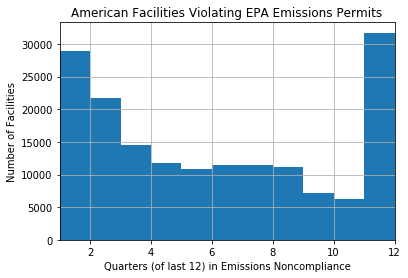

In [78]:
# sounds like a bell curve, let's get a visual

plt.hist(clean_data["FAC_QTRS_WITH_NC"], bins=11)
plt.title("American Facilities Violating EPA Emissions Permits")
plt.xlabel("Quarters (of last 12) in Emissions Noncompliance")
plt.ylabel("Number of Facilities")
plt.xlim(1, 12)
plt.grid()

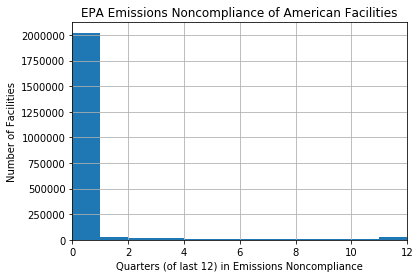

In [79]:
# not what I expected at all! How does this compare to the broader set including the non-violators?

plt.hist(echo_data["FAC_QTRS_WITH_NC"], bins=12)
plt.title("EPA Emissions Noncompliance of American Facilities")
plt.xlabel("Quarters (of last 12) in Emissions Noncompliance")
plt.ylabel("Number of Facilities")
plt.xlim(0, 12)
plt.grid()

So, most facilities haven't violated at all in the last 12 quarters. Among those who have, the number of violations is outlier-heavy. Let's dig a little deeper.

## Let's take a closer look at the compliance history column

It's a string, which can be decoded according to a key provided in the echo_exporter spreadsheet:

> Lists 12 quarters (3-month periods) with the following values:
> 
> * `S`= SNC/HPV/Serious Violation
> * `V`= violation/noncompliance
> * `U`= unknown
> * `_`= no violation identified
> 
> Order equals the priority if multiple permits are present

In [80]:
# what's going on with the 3-year compliance history column?

clean_data.dtypes

REGISTRY_ID                   float64
FAC_LAT                       float64
FAC_LONG                      float64
FAC_INSPECTION_COUNT            int64
FAC_INFORMAL_COUNT              int64
FAC_FORMAL_ACTION_COUNT         int64
FAC_PENALTY_COUNT             float64
FAC_QTRS_WITH_NC              float64
FAC_3YR_COMPLIANCE_HISTORY     object
dtype: object

In [81]:
print(clean_data.iloc[0]["FAC_3YR_COMPLIANCE_HISTORY"])
type(clean_data.iloc[0]["FAC_3YR_COMPLIANCE_HISTORY"])

UVVVS_VVSVVV


str

In [82]:
# re "order equals the priority..." – check that all vals in this column are the same length

length_check = clean_data["FAC_3YR_COMPLIANCE_HISTORY"].str.len() == 12
length_check.all()

True

In [83]:
clean_data["FAC_3YR_COMPLIANCE_HISTORY"]

1          UVVVS_VVSVVV
15         _V___VVVVVV_
28         __________V_
52         UUUVV_VVVVVV
56         ___________V
               ...     
2254663    VUUUUUUUUUU_
2254668    __V______VV_
2254674    V___________
2254683    SSSSSSSSSSSS
2254690    _U_VSSSSSSS_
Name: FAC_3YR_COMPLIANCE_HISTORY, Length: 166954, dtype: object

In [113]:
# codify types of noncompliance into their own columns

counted_data = clean_data.copy()

counted_data["VIOLATIONS_COUNT"] = clean_data["FAC_3YR_COMPLIANCE_HISTORY"].str.count('V') + clean_data["FAC_3YR_COMPLIANCE_HISTORY"].str.count('S')
counted_data["SERIOUS_VIOLATIONS_COUNT"] = clean_data["FAC_3YR_COMPLIANCE_HISTORY"].str.count('S')
counted_data["UNKNOWN_COUNT"] = clean_data["FAC_3YR_COMPLIANCE_HISTORY"].str.count('U')

# clean_data.iloc[0]["FAC_3YR_COMPLIANCE_HISTORY"].split('_')

In [114]:
counted_data.head()

,REGISTRY_ID,FAC_LAT,FAC_LONG,FAC_INSPECTION_COUNT,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_PENALTY_COUNT,FAC_QTRS_WITH_NC,FAC_3YR_COMPLIANCE_HISTORY,VIOLATIONS_COUNT,SERIOUS_VIOLATIONS_COUNT,UNKNOWN_COUNT
1,1.100643e+11,38.476060,-91.387974,0,0,0,NaN,10.0,UVVVS_VVSVVV,10,2,1
15,1.100100e+11,40.806111,-94.354722,0,0,0,NaN,7.0,_V___VVVVVV_,7,0,0
28,1.100067e+11,38.762985,-93.544405,0,0,0,NaN,1.0,__________V_,1,0,0
52,1.100054e+11,47.960000,-124.391944,1,0,0,NaN,8.0,UUUVV_VVVVVV,8,0,3
56,1.100706e+11,27.122555,-80.236136,1,0,0,NaN,1.0,___________V,1,0,0


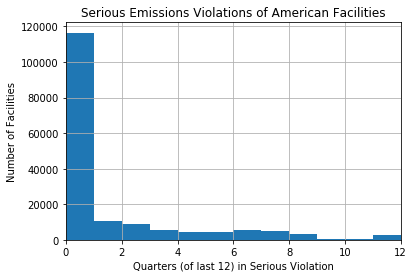

In [115]:
plt.hist(counted_data["SERIOUS_VIOLATIONS_COUNT"], bins=12)
plt.title("Serious Emissions Violations of American Facilities")
plt.xlabel("Quarters (of last 12) in Serious Violation")
plt.ylabel("Number of Facilities")
plt.xlim(0, 12)
plt.grid()

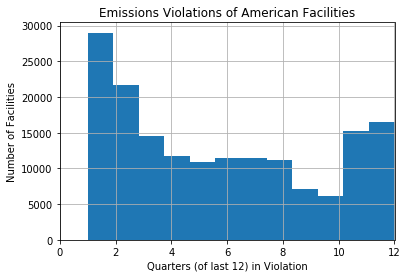

In [116]:
plt.hist(counted_data["VIOLATIONS_COUNT"], bins=12)
plt.title("Emissions Violations of American Facilities")
plt.xlabel("Quarters (of last 12) in Violation")
plt.ylabel("Number of Facilities")
plt.xlim(0, 12)
plt.grid()

## Let's start to explore enforcement

In [121]:
counted_data.describe()

,REGISTRY_ID,FAC_LAT,FAC_LONG,FAC_INSPECTION_COUNT,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_PENALTY_COUNT,FAC_QTRS_WITH_NC,VIOLATIONS_COUNT,SERIOUS_VIOLATIONS_COUNT,UNKNOWN_COUNT
count,1.613070e+05,165661.000000,165661.000000,166954.000000,166954.000000,166954.000000,9816.000000,166954.000000,166954.000000,166954.000000,166954.000000
mean,1.100343e+11,38.957013,-91.220175,1.163177,4.136894,0.337806,1.830277,5.674557,5.674557,1.300879,0.567246
std,2.424543e+07,6.035889,17.388487,3.199499,13.064365,2.686901,4.292196,3.819690,3.819690,2.548549,0.911893
min,1.100003e+11,-14.340056,-177.894500,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.100110e+11,35.390934,-97.311859,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,1.100385e+11,39.665545,-87.087936,0.000000,1.000000,0.000000,1.000000,5.000000,5.000000,0.000000,0.000000
75%,1.100529e+11,42.118515,-80.012092,1.000000,3.000000,0.000000,2.000000,9.000000,9.000000,1.000000,1.000000
max,1.100707e+11,71.575210,178.338813,436.000000,743.000000,529.000000,131.000000,12.000000,12.000000,12.000000,11.000000


### Formal enforcement action

Text(0, 0.5, 'Formal Actions in Preceding 5 Years')

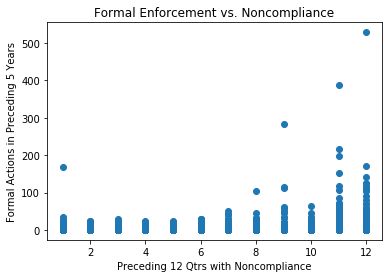

In [118]:
plt.scatter(counted_data["FAC_QTRS_WITH_NC"], counted_data["FAC_FORMAL_ACTION_COUNT"])
plt.title("Formal Enforcement vs. Noncompliance")
plt.xlabel("Preceding 12 Qtrs with Noncompliance")
plt.ylabel("Formal Actions in Preceding 5 Years")

Text(0, 0.5, 'Formal Actions in Preceding 5 Years')

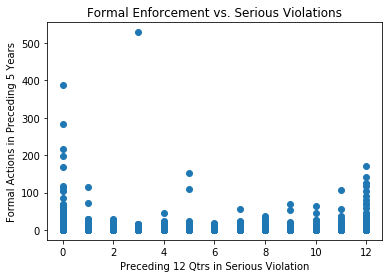

In [119]:
plt.scatter(counted_data["SERIOUS_VIOLATIONS_COUNT"], counted_data["FAC_FORMAL_ACTION_COUNT"])
plt.title("Formal Enforcement vs. Serious Violations")
plt.xlabel("Preceding 12 Qtrs in Serious Violation")
plt.ylabel("Formal Actions in Preceding 5 Years")

In [120]:
# enforcement via formal actions doesn't seem all that related to violations– what *is* correlated?

correlations = counted_data.corr()

# filter so it's (a) not showing columns correlated with themselves and (b) not showing tri
correlations[(correlations < 1) & (correlations > .7)]

,REGISTRY_ID,FAC_LAT,FAC_LONG,FAC_INSPECTION_COUNT,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_PENALTY_COUNT,FAC_QTRS_WITH_NC,VIOLATIONS_COUNT,SERIOUS_VIOLATIONS_COUNT,UNKNOWN_COUNT
REGISTRY_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_LAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_LONG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_INSPECTION_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_INFORMAL_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_FORMAL_ACTION_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,0.968793,NaN,NaN,NaN,NaN
FAC_PENALTY_COUNT,NaN,NaN,NaN,NaN,NaN,0.968793,NaN,NaN,NaN,NaN,NaN
FAC_QTRS_WITH_NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VIOLATIONS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SERIOUS_VIOLATIONS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Enforcement through formal actions is correlated to penalties (likely a tautological finding), and number of violations is correlated with quarters with noncompliance (also tautological).

**What is more interesting** is that enforcement actions (formal or informal) *are not significantly correlated* with the number of quarters of noncompliance, "serious" or not.

In [123]:
# just in case, let's add up all of the enforcement actions and check correlations again

more_counting = counted_data.copy()
more_counting["ENFORCEMENT_ACTIONS_COUNT"] = counted_data["FAC_INFORMAL_COUNT"] + counted_data["FAC_FORMAL_ACTION_COUNT"]
more_counting["ENFORCEMENT_AND_INSPECTION"] = counted_data["FAC_INFORMAL_COUNT"] + counted_data["FAC_FORMAL_ACTION_COUNT"] + counted_data["FAC_INSPECTION_COUNT"]

more_correlations = more_counting.corr()
more_correlations[(more_correlations < 1) & (more_correlations > .7)]

,REGISTRY_ID,FAC_LAT,FAC_LONG,FAC_INSPECTION_COUNT,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_PENALTY_COUNT,FAC_QTRS_WITH_NC,VIOLATIONS_COUNT,SERIOUS_VIOLATIONS_COUNT,UNKNOWN_COUNT,ENFORCEMENT_ACTIONS_COUNT,ENFORCEMENT_AND_INSPECTION
REGISTRY_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_LAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_LONG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_INSPECTION_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC_INFORMAL_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982632,0.954073
FAC_FORMAL_ACTION_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,0.968793,NaN,NaN,NaN,NaN,NaN,NaN
FAC_PENALTY_COUNT,NaN,NaN,NaN,NaN,NaN,0.968793,NaN,NaN,NaN,NaN,NaN,0.726514,NaN
FAC_QTRS_WITH_NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VIOLATIONS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SERIOUS_VIOLATIONS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


still no correlation between enforcement of any kind and violations